In [ ]:
! nvidia-smi

Thu Jun 25 10:59:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |  15523MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! rm -rf ./*
! git clone https://github.com/s910702s910702/DRIVE.git
! mv ./DRIVE/data ./

Cloning into 'DRIVE'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 242 (delta 46), reused 211 (delta 15), pack-reused 0
Receiving objects: 100% (242/242), 39.69 MiB | 12.58 MiB/s, done.
Resolving deltas: 100% (46/46), done.



# Model Part

In [ ]:
from google.colab.patches import cv2_imshow

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras


def unet(pretrained_weights = None,input_size = (576,592,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 288 296
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 144 148
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) # 72 74
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4) # 36 37
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # model.compile(optimizer = sgd(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

model = unet()

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 576, 592, 3) 0                                            
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 576, 592, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 576, 592, 64) 36928       conv2d_144[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 288, 296, 64) 0           conv2d_145[0][0]                 
____________________________________________________________________________________________

# Data

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os

def trainGenerate(batch_size, train_path, image_classes, mask_classes, aug_dict):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_classes],
        class_mode = None,
        color_mode = "rgb",
        target_size = (576, 592),
        batch_size = batch_size, 
        save_to_dir = None,
        save_prefix = "image",
        seed = 1
    )
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_classes],
        class_mode = None,
        color_mode = "grayscale",
        target_size = (576, 592),
        batch_size = batch_size, 
        save_to_dir = None,
        save_prefix = "mask",
        seed = 1
    )
    
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:       
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        yield (img,mask)

# Main code


In [ ]:
# Data generate args
data_gen_args = dict(
    rotation_range = 0.2,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.05, 
    zoom_range = 0.05, 
    horizontal_flip = True, 
    fill_mode = 'nearest'
)

In [ ]:
# Initial unet model
model = unet()
model_checkpoint = ModelCheckpoint('unet_DRIVE.hdf5', monitor='loss',verbose=1, save_best_only=True)

# train data set
trainData = trainGenerate(4, "data/train", "GB_image", "mask", data_gen_args)
model.fit(trainData, steps_per_epoch=300, epochs=10, callbacks=[model_checkpoint])

Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.9239
Epoch 00001: loss improved from inf to 0.19696, saving model to unet_DRIVE.hdf5
300/300 [==============================] - 243s 809ms/step - loss: 0.1970 - accuracy: 0.9239
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9595
Epoch 00002: loss improved from 0.19696 to 0.12811, saving model to unet_DRIVE.hdf5
300/300 [==============================] - 243s 809ms/step - loss: 0.1281 - accuracy: 0.9595
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9649
Epoch 00003: loss improved from 0.12811 to 0.11535, saving model to unet_DRIVE.hdf5
300/300 [==============================] - 243s 809ms/step - loss: 0.1153 - accuracy: 0.9649
Epoch 4/10
300/300 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9675
Epoch 000

In [ ]:
! pip3 install imagecodecs

In [ ]:
def testGenerator(test_path, num_image = 300, target_size = (576, 592),flag_multi_class = False,as_gray = False):
    for i in range(num_image):
        path = test_path + "%02d_test.tif" % (i + 1)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # img = io.imread(os.path.join(test_path,"%02d_test.tif" % (i + 1)),as_gray = as_gray)
        
        img = img / 255
        img = trans.resize(img, target_size)
        img = np.reshape(img, (1,) + img.shape)
        yield img

In [ ]:
testData = testGenerator("data/test/GB_afterMask/", 20)
results = model.predict(testData,verbose=1)

20/20 [==============================] - 2s 109ms/step


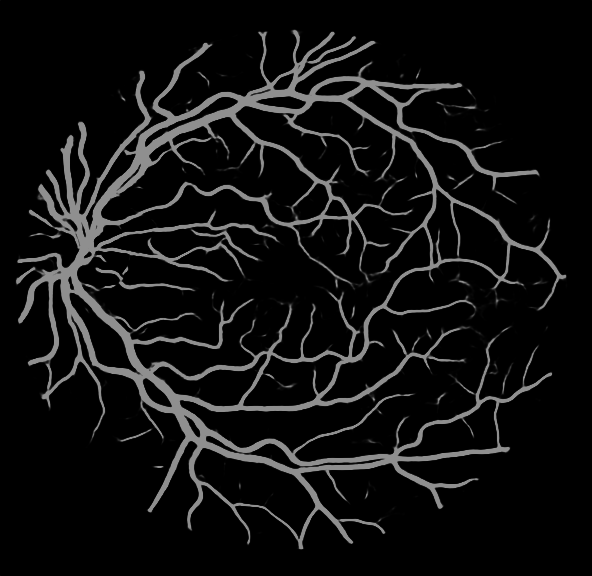

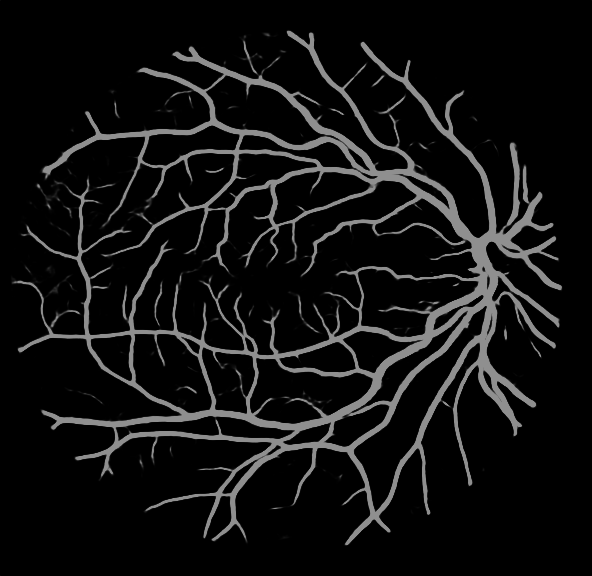

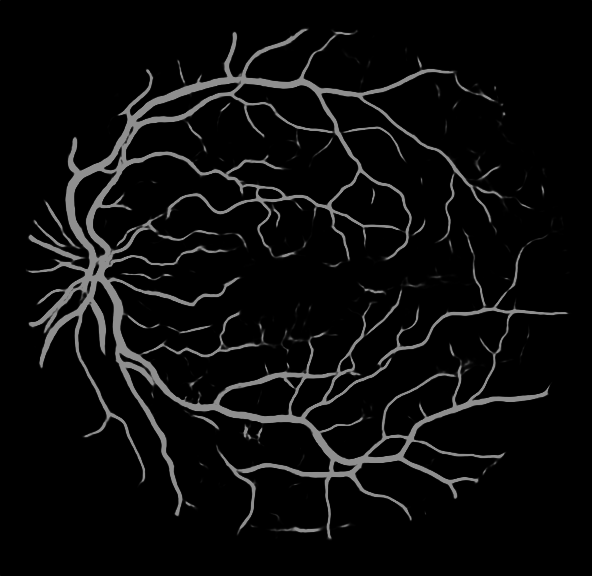

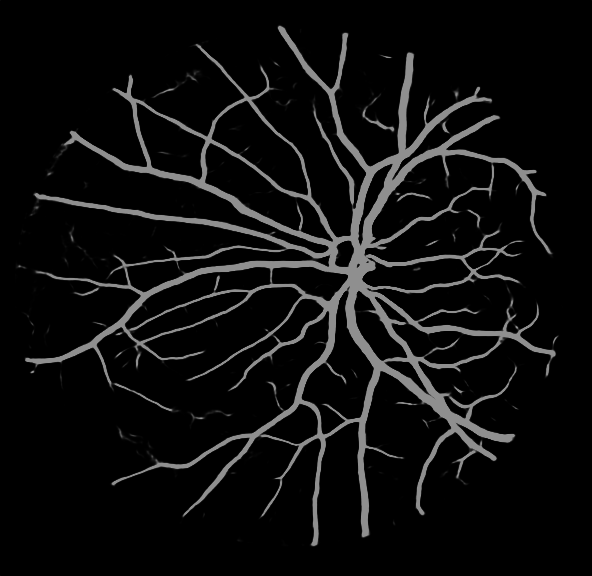

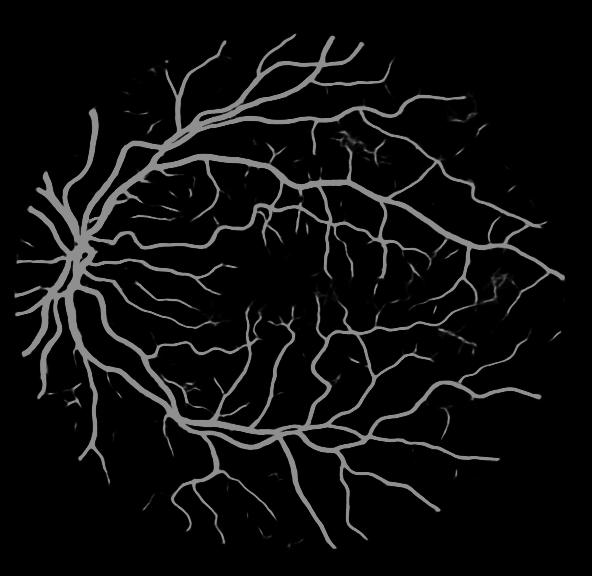

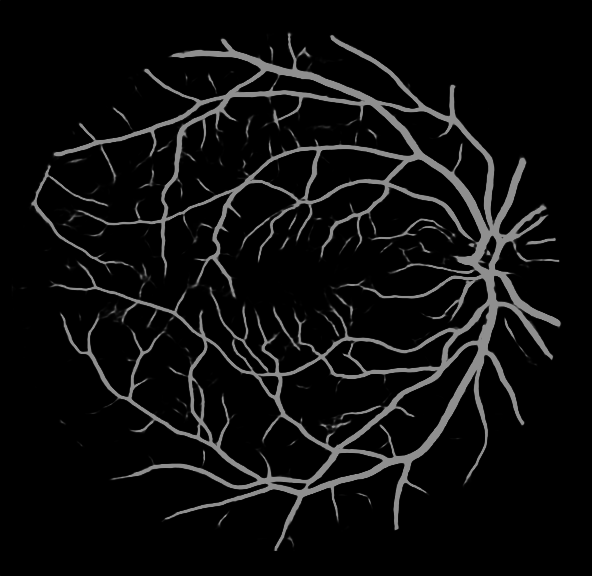

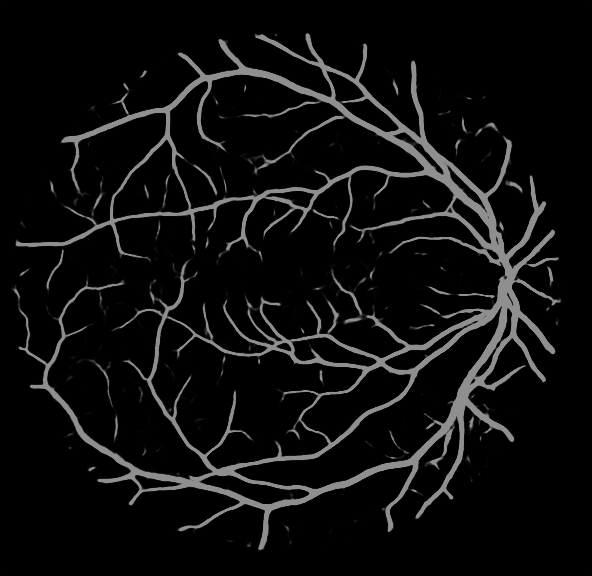

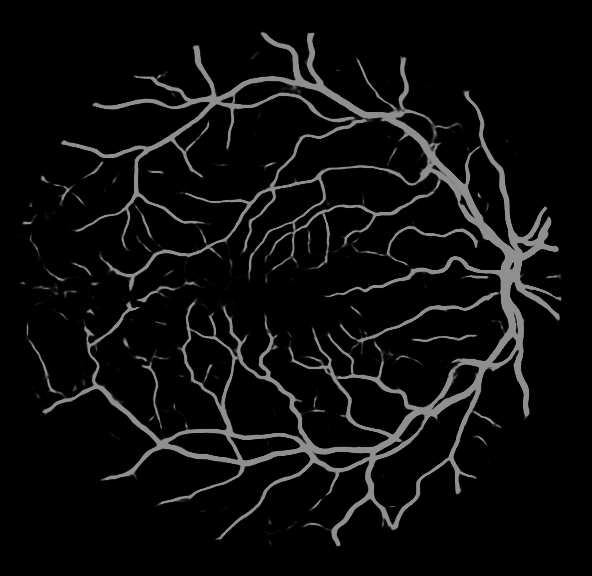

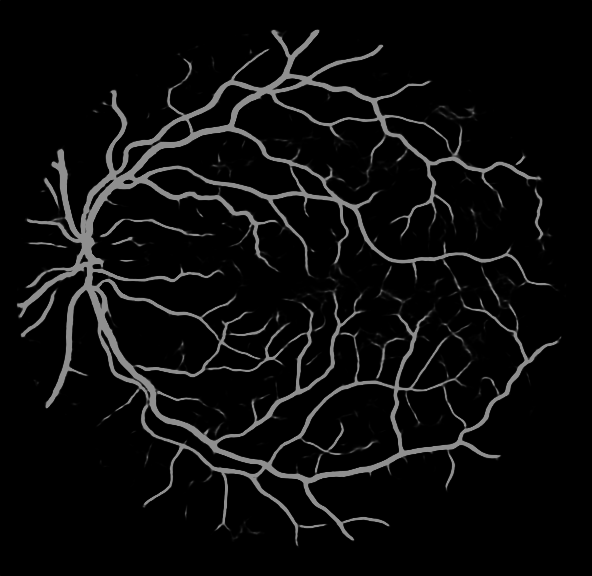

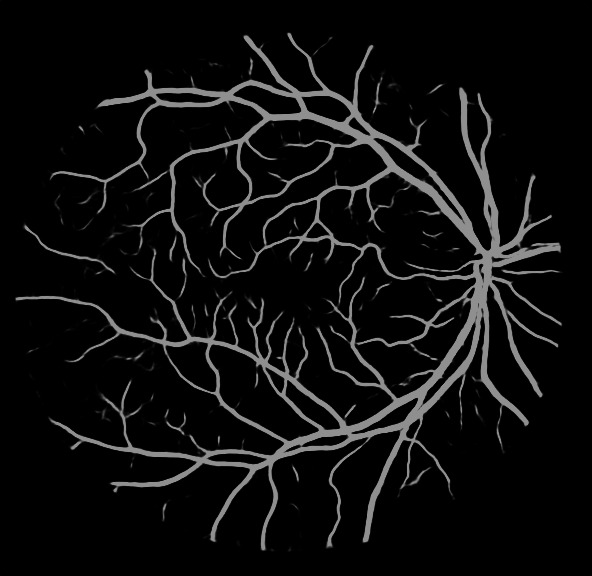

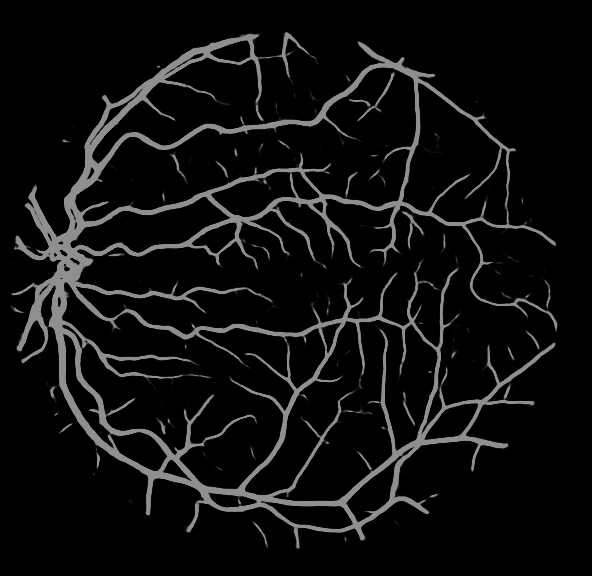

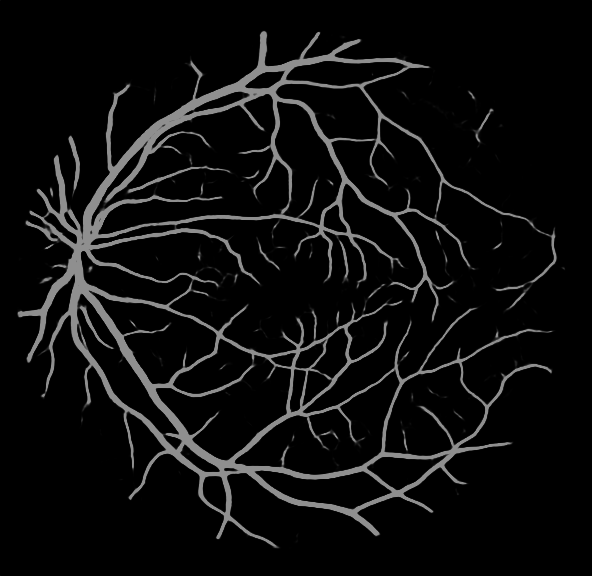

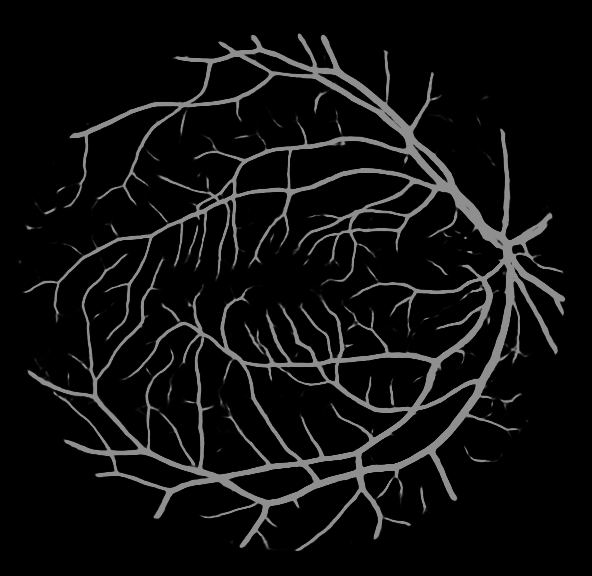

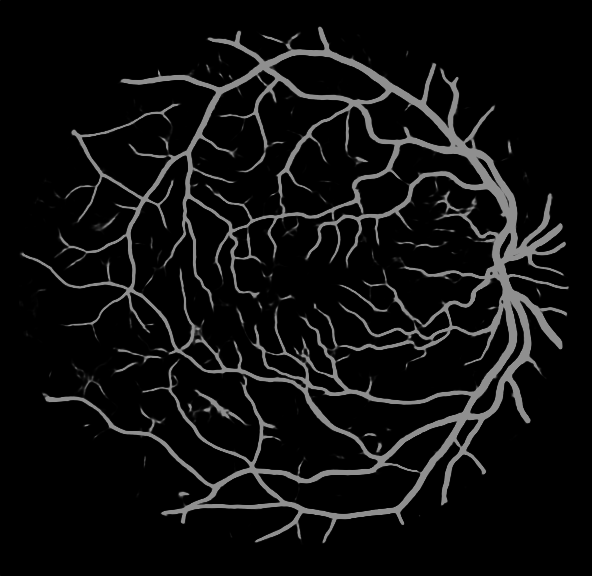

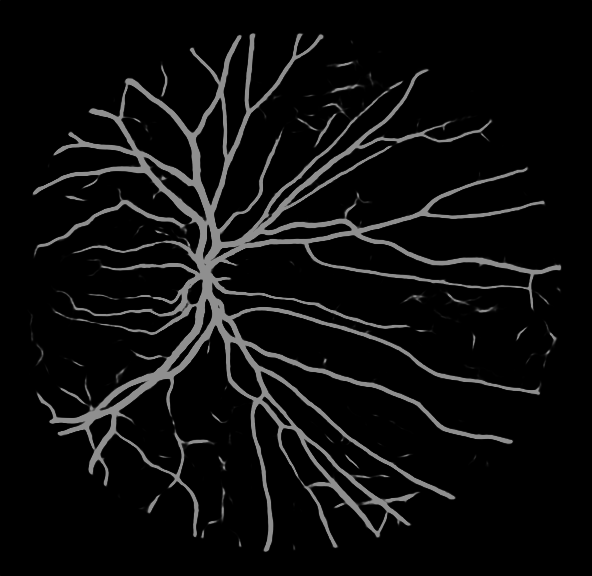

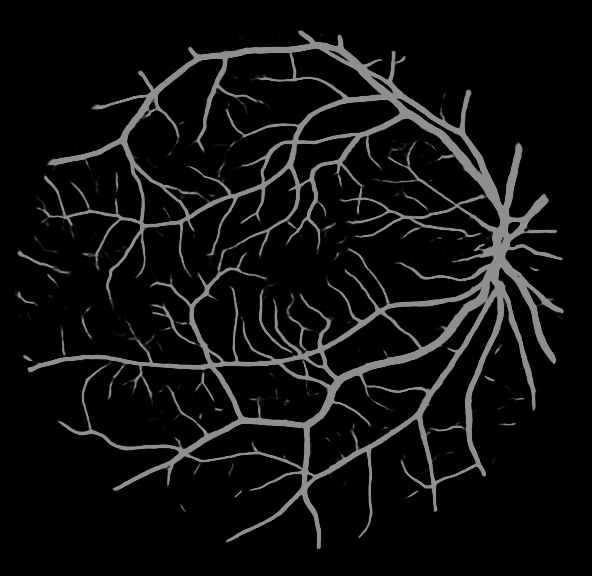

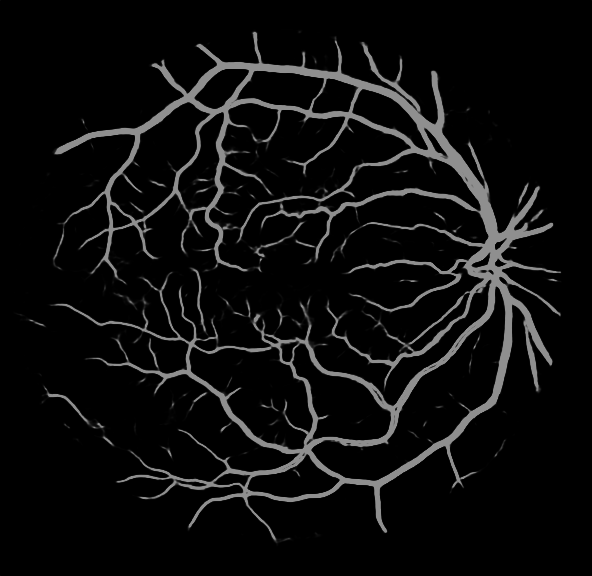

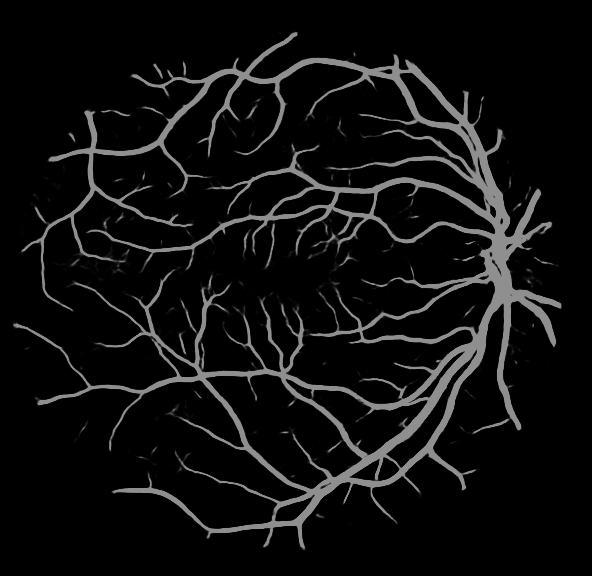

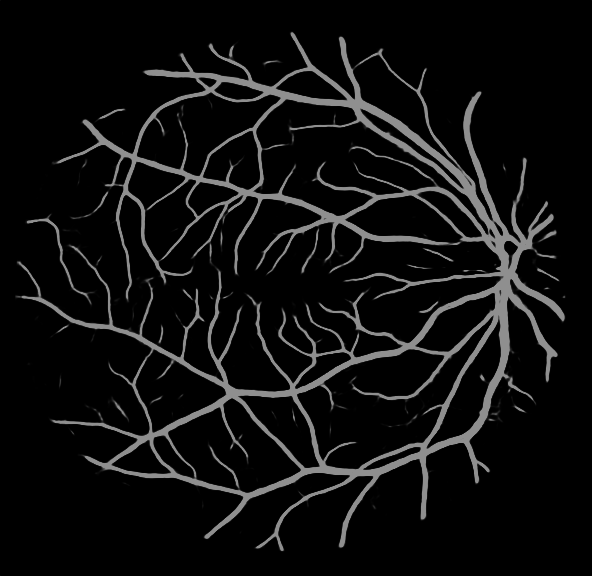

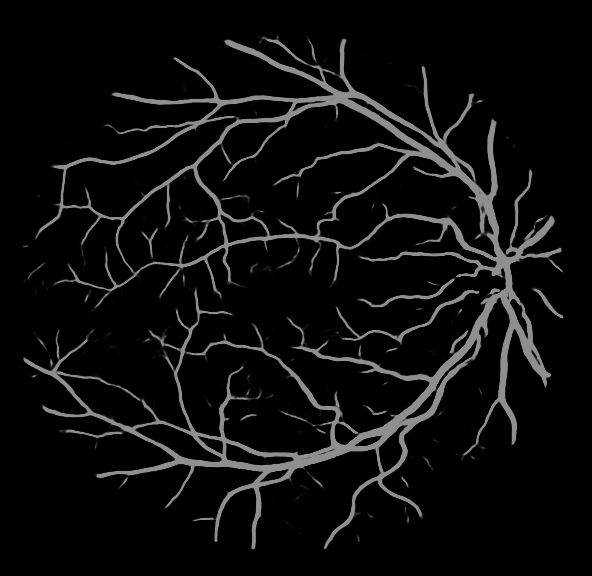

In [ ]:
for i,item in enumerate(results):
    img = item[:,:,0]
    img = (img * 255).astype('uint8') 
    ret, th = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    cv2_imshow(img)
    # cv2_imshow(th)